In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
import os
import datetime
from scipy import stats

In [2]:
# import data
lat = 25.03
if not os.path.exists('x_data.npy'):
    x_data = []
    effective_list = []
    solar_coefficient = []
    day_index = 1
    for yyyy in [2018, 2019, 2020]:
        for mm in range(1, 13):
            for dd in range(1, 32):
                # Check whether the date is valid
                isValidDate = True
                try :
                    datetime.datetime(yyyy, mm, dd)
                except ValueError :
                    isValidDate = False            
                if isValidDate and datetime.datetime(yyyy, mm, dd) < datetime.datetime(2020, 7, 13):
                    for zz in range(1, 9):
                        solar_declination = np.arcsin(np.sin(-23.44/180*np.pi)*np.cos((2*np.pi/365.24*(day_index%365+10))+(2*0.0167*np.sin(2*np.pi/365.24*(day_index%365-2))))) # in radiㄙ
                        cos_solar_zenith = np.sin(lat/180*np.pi)*np.sin(solar_declination) + np.cos(lat/180*np.pi)*np.cos(solar_declination)*np.cos(15*(zz-4)/180*np.pi)
                        solar_coefficient.append([[[cos_solar_zenith]]])
                        try:
                            # open image file
                            im = Image.open('img/vis_{:04d}_{:02d}_{:02d}_{:02d}LST.png'.format(yyyy, mm, dd, zz+8))
                            """
                            plt.figure(figsize=(16,16))
                            x1, x2 = 347, 357
                            y1, y2 = 135, 145
                            plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'r')
                            plt.imshow(im)
                            plt.show()
                            """
                            crop = im.crop((347, 135, 357, 145))
                            if (np.array(crop) == np.zeros((10, 10, 3))).all():
                                print('image file img/vis_{:04d}_{:02d}_{:02d}_{:02d}LST.png is empty'.format(yyyy, mm, dd, zz+8))
                                x_data.append(np.full((10, 10, 3), np.nan))
                                effective_list.append(False)
                            else:
                                x_data.append(np.array(crop))
                                effective_list.append(True)
                        except:
                            print('cannot identify image file img/vis_{:04d}_{:02d}_{:02d}_{:02d}LST.png'.format(yyyy, mm, dd, zz+8))
                            x_data.append(np.full((10, 10, 3), np.nan))
                            effective_list.append(False)
                        
                        day_index += 1
    x_data = np.array(x_data)
    np.save('x_data.npy', x_data)
    effective_list = np.array(effective_list)
    np.save('effective_list.npy', effective_list)
    solar_coefficient = np.array(solar_coefficient)
    np.save('solar_coefficient.npy', solar_coefficient)
else:
    x_data = np.load('x_data.npy')
    effective_list = np.load('effective_list.npy')
    solar_coefficient = np.load('solar_coefficient.npy')

In [3]:
train_data = np.concatenate((x_data.reshape((7392, 300))/255, solar_coefficient.reshape((7392, 1))), axis=1)
result = pd.read_csv('radiation.csv')
result.head()
X = train_data[effective_list]
Y = np.array(result['GloblRad'][effective_list])
print(X.shape)
print(Y.shape)
total = Y.shape[0]
print(total)

(7358, 301)
(7358,)
7358


In [4]:
np.isnan(X).sum()

0

In [5]:
split = total*4//5
# split trainig and testing data
x_train, y_train = X[:split], Y[:split] 
x_test, y_test = X[split:], Y[split:]
print(x_train.shape[1:])

(301,)


In [6]:
lr = LinearRegression()
gdbt = GradientBoostingRegressor(subsample=0.8, n_estimators=500, max_features='auto',
                                  max_depth=5, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500, max_features='auto', max_depth=5, bootstrap=True)

Loss:  0.6018928384640198
0.5519259672981167
slope: 0.5297661040515266
R2: 0.6229881151796853
p value: 1.10089126795e-313


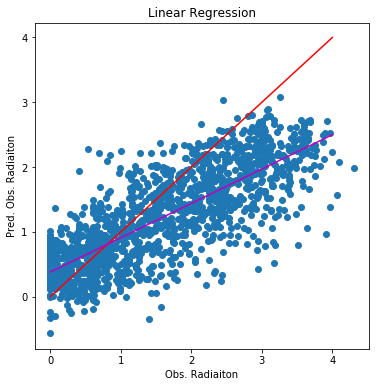

In [15]:
# logistic regression
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
loss = metrics.mean_squared_error(y_test, y_pred)
print("Loss: ", loss)
print(cross_val_score(lr, x_train, y_train, cv=5).mean())

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
print('slope:', slope)
print('R2:', r_value**2)
print('p value:', p_value)
plt.title('Linear Regression')
plt.plot([0, 4], [0*slope+intercept, 4*slope+intercept], 'm')
plt.show()

Loss:  0.5643002517817799
0.555731599563603
slope: 0.4867120231011084
R2: 0.6478593501801055
p value: 0.0


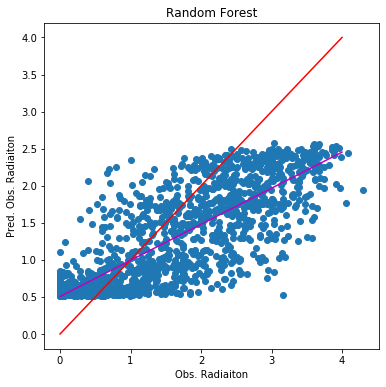

In [12]:
rf.fit(x_train, y_train)

# 預測測試集
y_pred = rf.predict(x_test)

loss = metrics.mean_squared_error(y_test, y_pred)
print("Loss: ", loss)
print(cross_val_score(rf, x_train, y_train, cv=5).mean())

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
print('slope:', slope)
print('R2:', r_value**2)
print('p value:', p_value)
plt.title('Random Forest')
plt.plot([0, 4], [0*slope+intercept, 4*slope+intercept], 'm')
plt.show()

Loss:  0.4533621469521599
0.6573406001695543
slope: 0.6000259477948104
R2: 0.7283104954502514
p value: 0.0


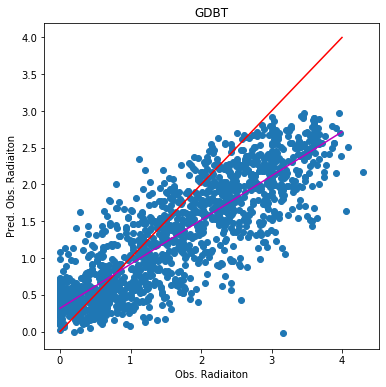

In [13]:
gdbt.fit(x_train, y_train)

# 預測測試集
y_pred = gdbt.predict(x_test)

loss = metrics.mean_squared_error(y_test, y_pred)
print("Loss: ", loss)
print(cross_val_score(gdbt, x_train, y_train, cv=5).mean())

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
print('slope:', slope)
print('R2:', r_value**2)
print('p value:', p_value)
plt.title('GDBT')
plt.plot([0, 4], [0*slope+intercept, 4*slope+intercept], 'm')
plt.show()

Loss:  0.7054343586956522
0.48301559184460957
slope: 0.5330740746731035
R2: 0.5813001175494087
p value: 3.422801522990758e-280


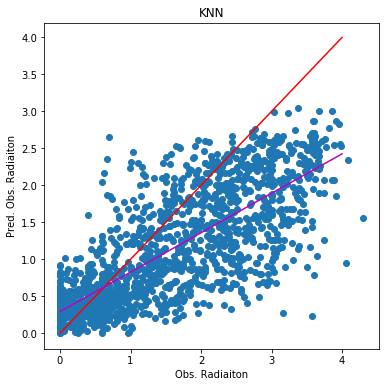

In [14]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

loss = metrics.mean_squared_error(y_test, y_pred)
print("Loss: ", loss)
print(cross_val_score(knn, x_train, y_train, cv=5).mean())

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 4], [0, 4], 'r')
plt.xlabel('Obs. Radiaiton')
plt.ylabel('Pred. Obs. Radiaiton')
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred)
print('slope:', slope)
print('R2:', r_value**2)
print('p value:', p_value)
plt.title('KNN')
plt.plot([0, 4], [0*slope+intercept, 4*slope+intercept], 'm')
plt.show()